In [1]:
import numpy as np

from PIL import Image

import numpy as np
import time

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches

import mss
import cv2

import math


In [2]:
def cosd(x):
    return np.cos(x * np.pi / 180)

def sind(x):
    return np.sin(x * np.pi / 180)

def tand(x):
    return np.tan(x * np.pi / 180)

# Load in the Images

In [3]:
es = np.linspace(-80, 80, 10)
us = np.linspace(-50, 50, 10)

In [4]:
ims = np.zeros((10, 10, 1080, 1920, 3), dtype=int)
idx = 0
for i in range(10):
    for j in range(10):
        ims[i, j, :, :, :] = np.array(cv2.cvtColor(cv2.imread(
            '../test_data/' + str(idx) + '.jpg'), cv2.COLOR_BGRA2BGR)[:, :, ::-1])
        idx += 1


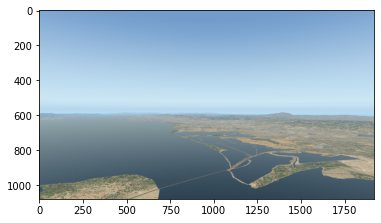

In [21]:
plt.imshow(ims[0, 0, :, :, :])

# Horizontal Tuning

### Display Horizontal Images

In [5]:
def show_imgs(ims, grid_dims=(2, 5), figsize=(8., 8.)):
    fig = plt.figure(figsize=figsize)

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=grid_dims,  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for (i, ax) in enumerate(grid):
        ax.imshow(ims[i])


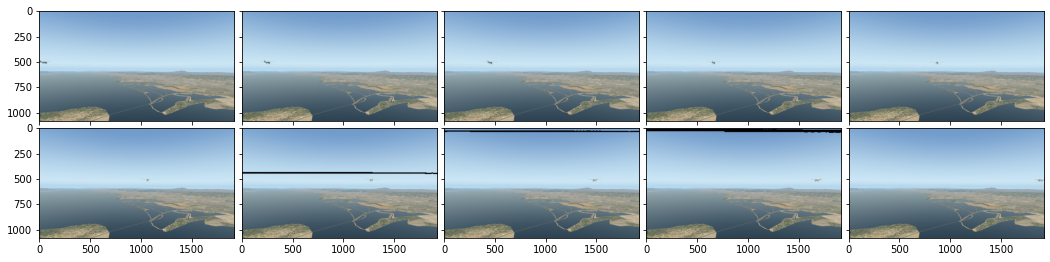

In [33]:
show_imgs(ims[:, 5, :, :, :], grid_dims=(2, 5), figsize=(18, 12))

### Display Center Estimates

In [6]:
def get_center(e0, n0, u0, h0, e1, n1, u1, hfov=90, aspect_ratio=1440/2560, w=1920, h=1080):
    # Make ownship be the origin
    x = n1 - n0
    y = -(e1 - e0)  # right-handed coordinates
    z = u1 - u0

    # Rotate x and y according to ownship heading
    xrot = x * cosd(h0) - y * sind(h0)
    yrot = -(x * sind(h0) + y * cosd(h0))

    # https://www.youtube.com/watch?v=LhQ85bPCAJ8
    xp = yrot / (xrot * tand(hfov / 2))
    vfov = hfov * aspect_ratio
    yp = z / (xrot * tand(vfov / 2))

    # Get xp and yp between 0 and 1
    xp = (xp + 1) / 2
    yp = (yp + 1) / 2

    # Map to pixel location
    xp = xp * w
    yp = (1 - yp) * h

    return xp, yp

In [7]:
def show_imgs_w_centers(ims, es, us, grid_dims=(2, 5), figsize=(8., 8.), hfov=90, aspect_ratio=1440/2560):
    fig = plt.figure(figsize=figsize)

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=grid_dims,  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for (i, ax) in enumerate(grid):
        ax.imshow(ims[i])
        xp, yp = get_center(0, 0, 0, 0, es[i], 100, us[i], hfov=hfov,
                   aspect_ratio=aspect_ratio, w=1920, h=1080)
        ax.scatter(xp, yp, color="red", s=10)

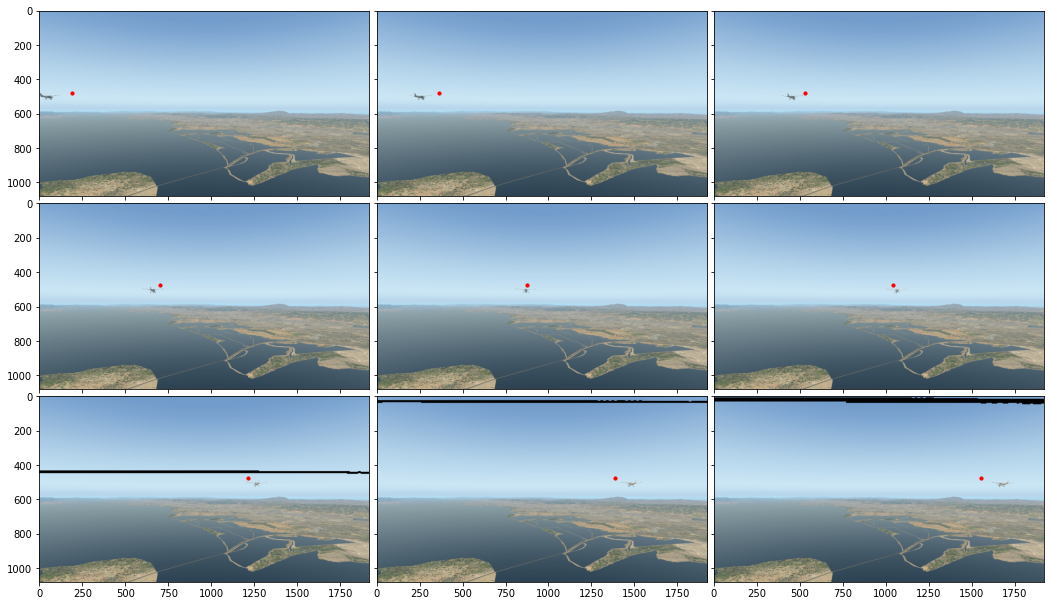

In [8]:
show_imgs_w_centers(ims[:9, 5, :, :, :], es, us[5] * np.ones(10),
                    grid_dims=(3, 3), figsize=(18, 12))

# Interactive FOV Tuning

In [9]:
import ipywidgets as widgets
from ipywidgets import interact

In [31]:
# def tuning_interact(hfov):
#     show_imgs_w_centers(ims[:9, 5, :, :, :], es, us[5] * np.ones(10),
#                         grid_dims=(3, 3), figsize=(18, 12), hfov=hfov)

def tuning_interact(hfov):
    show_imgs_w_centers(ims[5, 1:, :, :, :], es[5] * np.ones(10), us,
                        grid_dims=(3, 3), figsize=(18, 12), hfov=hfov)

interact(tuning_interact,
        hfov=widgets.FloatSlider(min=78, max=82, step=0.25, value=80))


interactive(children=(FloatSlider(value=80.0, description='hfov', max=82.0, min=78.0, step=0.25), Output()), _…

<function __main__.tuning_interact(hfov)>

# Accounting for Camera Tilt

In [11]:
def get_center_tilt(e0, n0, u0, h0, e1, n1, u1, hfov=90, tilt=10, aspect_ratio=1440/2560, w=1920, h=1080):
    # Make ownship be the origin
    x = n1 - n0
    y = -(e1 - e0)  # right-handed coordinates
    z = u1 - u0

    # Rotate x and y according to ownship heading
    xrot = x * cosd(h0) - y * sind(h0)
    yrot = -(x * sind(h0) + y * cosd(h0))

    # Rotate z according to tilt angle
    xcam = xrot * cosd(tilt) - z * sind(tilt)
    ycam = yrot
    zcam = xrot * sind(tilt) + z * cosd(tilt)

    # https://www.youtube.com/watch?v=LhQ85bPCAJ8
    xp = ycam / (xcam * tand(hfov / 2))
    vfov = hfov * aspect_ratio
    yp = zcam / (xcam * tand(vfov / 2))

    # Get xp and yp between 0 and 1
    xp = (xp + 1) / 2
    yp = (yp + 1) / 2

    # Map to pixel location
    xp = xp * w
    yp = (1 - yp) * h

    return xp, yp

In [12]:
def show_imgs_w_centers_tilt(ims, es, us, grid_dims=(2, 5), figsize=(8., 8.), hfov=90, tilt=10, aspect_ratio=1440/2560):
    fig = plt.figure(figsize=figsize)

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=grid_dims,  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for (i, ax) in enumerate(grid):
        ax.imshow(ims[i])
        xp, yp = get_center_tilt(0, 0, 0, 0, es[i], 100, us[i], hfov=hfov, tilt=tilt,
                            aspect_ratio=aspect_ratio, w=1920, h=1080)
        ax.scatter(xp, yp, color="red", s=10)

In [13]:
def tuning_interact_tilt(hfov, tilt):
    show_imgs_w_centers_tilt(ims[5, 1:, :, :, :], es[5] * np.ones(10), us[1:],
                        grid_dims=(3, 3), figsize=(18, 12), hfov=hfov, tilt=tilt)


interact(tuning_interact_tilt,
         hfov=widgets.FloatSlider(min=78, max=82, step=0.25, value=80),
         tilt=widgets.FloatSlider(min=-20, max=20, step=2, value=-1.5))

interactive(children=(FloatSlider(value=80.0, description='hfov', max=82.0, min=78.0, step=0.25), FloatSlider(…

<function __main__.tuning_interact_tilt(hfov, tilt)>

# Allow Different Vertical FOV

In [48]:
def get_center_fov(e0, n0, u0, h0, e1, n1, u1, hfov=90, vfov=0.5625*80, offset=0, tilt=10, w=1920, h=1080):
    # Make ownship be the origin
    x = n1 - n0
    y = -(e1 - e0)  # right-handed coordinates
    z = u1 - u0

    # Rotate x and y according to ownship heading
    xrot = x * cosd(h0) - y * sind(h0)
    yrot = -(x * sind(h0) + y * cosd(h0))

    # Offset
    z = z + offset

    # Rotate z according to tilt angle
    xcam = xrot * cosd(tilt) - z * sind(tilt)
    ycam = yrot
    zcam = xrot * sind(tilt) + z * cosd(tilt)

    # https://www.youtube.com/watch?v=LhQ85bPCAJ8
    xp = ycam / (xcam * tand(hfov / 2))
    yp = zcam / (xcam * tand(vfov / 2))

    # Get xp and yp between 0 and 1
    xp = (xp + 1) / 2
    yp = (yp + 1) / 2

    # Map to pixel location
    xp = xp * w
    yp = (1 - yp) * h

    return xp, yp

In [49]:
def show_imgs_w_centers_fov(ims, es, us, grid_dims=(2, 5), figsize=(8., 8.), hfov=90, vfov=45, offset=0, tilt=10):
    fig = plt.figure(figsize=figsize)

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=grid_dims,  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for (i, ax) in enumerate(grid):
        ax.imshow(ims[i])
        xp, yp = get_center_fov(0, 0, 0, 0, es[i], 100, us[i], hfov=hfov, vfov=vfov, offset=offset, tilt=tilt, w=1920, h=1080)
        ax.scatter(xp, yp, color="red", s=10)

In [16]:
xp, yp = get_center_fov(
    0, 0, 0, 0, es[5], 100, us[0], hfov=80, vfov=50, tilt=4, w=1920, h=1080)
xp, yp

(1058.500717992238, 1021.2143678773482)

In [52]:
# def tuning_interact_fov(hfov, vfov, tilt):
#     show_imgs_w_centers_fov(ims[5, 1:, :, :, :], es[5] * np.ones(10), us[1:],
#                              grid_dims=(3, 3), figsize=(18, 12), hfov=hfov, vfov=vfov, tilt=tilt)

def tuning_interact_fov(hfov, vfov, offset, tilt):
    show_imgs_w_centers_fov(ims[1:, 5, :, :, :], es[1:], us[5] * np.ones(9),
                            grid_dims=(3, 3), figsize=(18, 12), hfov=hfov, vfov=vfov, offset=offset, tilt=tilt)

# interact(tuning_interact_fov,
#          hfov=widgets.FloatSlider(min=78, max=82, step=0.25, value=80),
#          vfov=widgets.FloatSlider(min=36, max=70, step=2, value=(1080/1920)*80),
#          tilt=widgets.FloatSlider(min=-20, max=20, step=2, value=0))

interact(tuning_interact_fov,
         hfov=widgets.FloatSlider(min=78, max=82, step=0.25, value=80),
         vfov=widgets.FloatSlider(min=48, max=52, step=0.25, value=50.25),
         offset=widgets.FloatSlider(min=-10, max=10, step=0.25, value=-5),
         tilt=widgets.FloatSlider(min=-2, max=0, step=0.25, value=0))


interactive(children=(FloatSlider(value=80.0, description='hfov', max=82.0, min=78.0, step=0.25), FloatSlider(…

<function __main__.tuning_interact_fov(hfov, vfov, offset, tilt)>

# Final Checks Over 100m Grid

In [33]:
def show_img_w_center(im, e, u, hfov=80, vfov=50.25, tilt=-1.5):
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    
    xp, yp = get_center_fov(
            0, 0, 0, 0, e, 100, u, hfov=hfov, vfov=vfov, tilt=tilt, w=1920, h=1080)
    plt.scatter(xp, yp, color="red", s=10)
    plt.imshow(im)

In [34]:
def total_interact(ei, ui, hfov, vfov, tilt):
    show_img_w_center(ims[ei, ui, :, :, :], es[ei], us[ui] * np.ones(9), hfov=hfov, vfov=vfov, tilt=tilt)

interact(total_interact,
         hfov=widgets.FloatSlider(min=78, max=82, step=0.25, value=80),
         vfov=widgets.FloatSlider(min=48, max=52, step=0.25, value=50.25),
         tilt=widgets.FloatSlider(min=-3, max=-1, step=0.25, value=-1.5),
         ei=widgets.IntSlider(min=0, max=9, step=1),
         ui=widgets.IntSlider(min=0, max=9, step=1))

interactive(children=(IntSlider(value=0, description='ei', max=9), IntSlider(value=0, description='ui', max=9)…

<function __main__.total_interact(ei, ui, hfov, vfov, tilt)>

# Checks Over Random Test Data

### Load in the Images

In [20]:
data_ims = np.zeros((50, 1080, 1920, 3), dtype=int)
for i in range(50):
    data_ims[i, :, :, :] = np.array(cv2.cvtColor(cv2.imread(
        '../data/' + str(i) + '.jpg'), cv2.COLOR_BGRA2BGR)[:, :, ::-1])

### Load in the States

In [21]:
import pandas as pd

In [22]:
df = pd.read_csv('../data/state_data.csv')

In [36]:
def show_img_w_center(im, e0, n0, u0, h0, e1, n1, u1, hfov=80, vfov=50.25, tilt=-1.5):
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)

    xp, yp = get_center_fov(
        e0, n0, u0, h0, e1, n1, u1, hfov=hfov, vfov=vfov, tilt=tilt, w=1920, h=1080)
    plt.scatter(xp, yp, color="red", s=10)
    plt.imshow(im)

In [50]:
def data_interact(i, hfov, vfov, tilt):
    show_img_w_center(data_ims[i, :, :, :], df['e0'][i], df['n0'][i], df['u0'][i], df['h0'][i], df['e1'][i],
                      df['n1'][i], df['u1'][i], hfov=hfov, vfov=vfov, tilt=tilt)

interact(data_interact,
         hfov=widgets.FloatSlider(min=78, max=82, step=0.25, value=80),
         vfov=widgets.FloatSlider(min=48, max=52, step=0.25, value=50.25),
         tilt=widgets.FloatSlider(min=-3, max=-1, step=0.25, value=-1.5),
         i=widgets.IntSlider(min=0, max=49, step=1))

interactive(children=(IntSlider(value=0, description='i', max=49), FloatSlider(value=80.0, description='hfov',…

<function __main__.data_interact(i, hfov, vfov, tilt)>

# Bounding Box Tuning

In [72]:
def get_bounding_box(e0, n0, u0, h0, e1, n1, u1, hfov=80, vfov=50.25, offset=0, tilt=0, sw=1920, sh=1080, aw0=0, daw=1):
    # Make ownship be the origin
    x = n1 - n0
    y = -(e1 - e0) # right-handed coordinates
    z = u1 - u0

    # Rotate x and y according to ownship heading
    xrot = x * cosd(h0) - y * sind(h0)
    yrot = -(x * sind(h0) + y * cosd(h0))

    # Account for offset
    z = z + offset

    # Rotate z according to tilt angle
    xcam = xrot * cosd(tilt) - z * sind(tilt)
    ycam = yrot
    zcam = xrot * sind(tilt) + z * cosd(tilt)

    # https://www.youtube.com/watch?v=LhQ85bPCAJ8
    xp = ycam / (xcam * tand(hfov / 2))
    yp = zcam / (xcam * tand(vfov / 2))

    # Get xp and yp between 0 and 1
    xp = (xp + 1) / 2
    yp = (yp + 1) / 2

    # Map to pixel location
    xp = xp * sw
    yp = (1 - yp) * sh

    # Get height and width of bounding box
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    w = daw * (1 / r) + aw0
    h = (3 / 8) * w

    # print(r)

    return xp, yp, w, h

In [29]:
def show_img_w_bb(im, xp, yp, w, h):
    f, ax = plt.subplots()
    f.set_figwidth(14)
    f.set_figheight(14)

    ax.imshow(im)

    rect = patches.Rectangle((xp - (w / 2), yp - (h / 2)), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [74]:
def data_interact_bb(i, aw0, daw, hfov, vfov, offset, tilt):
    xp, yp, w, h = get_bounding_box(df['e0'][i], df['n0'][i], df['u0'][i], df['h0'][i], df['e1'][i],
                                    df['n1'][i], df['u1'][i], aw0=aw0, daw=daw, hfov=hfov, vfov=vfov, offset=offset, tilt=tilt)
    # print(w)
    # print(h)
    show_img_w_bb(data_ims[i, :, :, :], xp, yp, w, h)

interact(data_interact_bb,
         aw0=widgets.FloatSlider(min=-10, max=10, step=1, value=0),
         daw=widgets.FloatSlider(min=13000, max=18000, step=200, value=17000),
         hfov=widgets.FloatSlider(min=78, max=82, step=0.2, value=80),
         vfov=widgets.FloatSlider(min=40, max=52, step=0.25, value=50.75),
         offset=widgets.FloatSlider(min=-10, max=10, step=0.25, value=0),
         tilt=widgets.FloatSlider(min=-2, max=0, step=0.05, value=-1.25),
         i=widgets.IntSlider(min=0, max=49, step=1, value=10))


interactive(children=(IntSlider(value=10, description='i', max=49), FloatSlider(value=0.0, description='aw0', …

<function __main__.data_interact_bb(i, aw0, daw, hfov, vfov, offset, tilt)>

In [55]:
def show_imgs_w_bbs(im_inds, grid_dims=(3, 3), figsize=(18., 12.), hfov=90, vfov=45, offset=0, tilt=10, daw=15200, aw0=0):
    fig = plt.figure(figsize=figsize)

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=grid_dims,  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for (i, ax) in zip(im_inds, grid):
        ax.imshow(data_ims[i])
        xp, yp, w, h = get_bounding_box(df['e0'][i], df['n0'][i], df['u0'][i], df['h0'][i], df['e1'][i],
                                        df['n1'][i], df['u1'][i], aw0=aw0, daw=daw, hfov=hfov, vfov=vfov, offset=offset, tilt=tilt)
        rect = patches.Rectangle(
            (xp - (w / 2), yp - (h / 2)), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

In [80]:
def data_interact_bb(i, aw0, daw, hfov, vfov, offset, tilt):
    xp, yp, w, h = get_bounding_box(tdf['e0'][i], tdf['n0'][i], tdf['u0'][i], tdf['h0'][i], tdf['e1'][i],
                                    tdf['n1'][i], tdf['u1'][i], aw0=aw0, daw=daw, hfov=hfov, vfov=vfov, offset=offset, tilt=tilt)
    # print(w)
    # print(h)
    show_img_w_bb(tdata_ims[i, :, :, :], xp, yp, w, h)

interact(data_interact_bb,
         aw0=widgets.FloatSlider(min=-10, max=10, step=1, value=0),
         daw=widgets.FloatSlider(min=13000, max=18000, step=200, value=17000),
         hfov=widgets.FloatSlider(min=78, max=82, step=0.2, value=80),
         vfov=widgets.FloatSlider(min=40, max=52, step=0.25, value=50.75),
         offset=widgets.FloatSlider(min=-10, max=10, step=0.25, value=0),
         tilt=widgets.FloatSlider(min=-2, max=0, step=0.05, value=-1.25),
         i=widgets.IntSlider(min=0, max=49, step=1, value=10))


interactive(children=(IntSlider(value=10, description='i', max=49), FloatSlider(value=0.0, description='aw0', …

<function __main__.data_interact_bb(i, aw0, daw, hfov, vfov, offset, tilt)>

# Try Large Dataset

In [75]:
tdata_ims = np.zeros((50, 1080, 1920, 3), dtype=int)
for i in range(50):
    tdata_ims[i, :, :, :] = np.array(cv2.cvtColor(cv2.imread(
        '../trafficdata/' + str(i) + '.jpg'), cv2.COLOR_BGRA2BGR)[:, :, ::-1])

In [77]:
tdf = pd.read_csv('../trafficdata/state_data.csv')

In [78]:
def show_imgs_w_bbs(im_inds, grid_dims=(3, 3), figsize=(18., 12.), hfov=90, vfov=45, offset=0, tilt=10, daw=15200, aw0=0):
    fig = plt.figure(figsize=figsize)

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=grid_dims,  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for (i, ax) in zip(im_inds, grid):
        ax.imshow(tdata_ims[i])
        xp, yp, w, h = get_bounding_box(tdf['e0'][i], tdf['n0'][i], tdf['u0'][i], tdf['h0'][i], tdf['e1'][i],
                                        tdf['n1'][i], tdf['u1'][i], aw0=aw0, daw=daw, hfov=hfov, vfov=vfov, offset=offset, tilt=tilt)
        rect = patches.Rectangle(
            (xp - (w / 2), yp - (h / 2)), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

In [79]:
def interact_bb(aw0, daw, hfov, vfov, offset, tilt):
    #show_imgs_w_bbs([0, 1, 2, 3, 4, 5, 6, 7, 8], aw0=aw0, daw=daw, hfov=hfov, vfov=vfov, offset=offset, tilt=tilt)
    # show_imgs_w_bbs([0, 2, 3, 8], aw0=aw0, daw=daw,
    #                 hfov=hfov, vfov=vfov, offset=offset, tilt=tilt, grid_dims=(2, 2))
    show_imgs_w_bbs([44, 45, 46, 47], aw0=aw0, daw=daw,
                    hfov=hfov, vfov=vfov, offset=offset, tilt=tilt, grid_dims=(2, 2))


interact(interact_bb,
         aw0=widgets.FloatSlider(min=-10, max=10, step=1, value=0),
         daw=widgets.FloatSlider(min=15000, max=16000, step=1000, value=17000),
         hfov=widgets.FloatSlider(min=78, max=82, step=0.2, value=80),
         vfov=widgets.FloatSlider(min=40, max=52, step=0.1, value=50.5),
         offset=widgets.FloatSlider(min=-10, max=10, step=0.25, value=0),
         tilt=widgets.FloatSlider(min=-2, max=0, step=0.1, value=-1))

interactive(children=(FloatSlider(value=0.0, description='aw0', max=10.0, min=-10.0, step=1.0), FloatSlider(va…

<function __main__.interact_bb(aw0, daw, hfov, vfov, offset, tilt)>

In [45]:
80 * (1080  / 1920)

45.0

In [168]:
78-194

-116

In [169]:
-116/140

-0.8285714285714286

In [170]:
215 + 78*0.83

279.74

In [81]:
len(df)

50